## Data importing

In [2]:
paths = ["./data/s" + str(i) for i in range(1, 41)]
print(paths[0])
print(paths[1])

./data/s1
./data/s2


(92, 112)


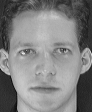

In [3]:
from PIL import Image
img = Image.open('./data/s1/1.pgm')
print(img.size)
img

## Converting to Matrix

In [4]:
import os
import numpy as np

data = []

for path in paths:
    files = os.listdir(path)

    for file in files:
        img = Image.open(path + "/" + file)
        img = np.array(img)
        img = img.flatten()
        data.append(img)
        
data = np.array(data)
data.shape

(400, 10304)

In [5]:
labels = []

for i in range(1, 41):
    tmp = [i] * 10
    labels += tmp

labels = np.array(labels)
labels.shape

(400,)

## Data splitting

In [24]:
x_train = []
x_test = []
y_train = []
y_test = []

for i in range(data.shape[0]):
    if (i+1) % 2 == 0:
        x_test.append(data[i])
        y_test.append(labels[i])
    else:
        x_train.append(data[i])
        y_train.append(labels[i])

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)



(200, 10304)
(200, 10304)
(200,)
(200,)


PCA

In [26]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


alphas = [0.8, 0.85, 0.9, 0.95]

for alpha in alphas:
    pca = PCA(n_components=alpha)
    x_train_pca = pca.fit_transform(x_train)
    x_test_pca = pca.transform(x_test)

    classifier = KNeighborsClassifier(n_neighbors=1)
    classifier.fit(x_train_pca, y_train)


    predictions = classifier.predict(x_test_pca)

    accuracy = accuracy_score(y_test, predictions)
    print(f'accuracy_score for alpha {alpha}: {accuracy}')



accuracy_score for alpha 0.8: 0.945
accuracy_score for alpha 0.85: 0.94
accuracy_score for alpha 0.9: 0.94
accuracy_score for alpha 0.95: 0.93


## Classification using PCA

In [19]:
# diaa
import numpy as np

alphas = [0.8, 0.85, 0.9, 0.95]


def PCA(D, alpha):
    n = D.shape[0]
    #compute the mean
    mu = np.mean(D, axis=0)
    # center the data
    z = D - mu
    #covariance matrix
    sigma = (1/n) * np.dot(z.T, z)
    
    #eigen values
    eigen_values, eigen_vectors = np.linalg.eig(sigma)

    sorted_indices = np.argsort(eigen_values)[::-1]
    eigen_values = eigen_values[sorted_indices]
    eigen_vectors = eigen_vectors[:, sorted_indices]

    total_variance = np.sum(eigen_values)

    r = next(i for i, x in enumerate(np.cumsum(eigen_values) / total_variance) if x >= alpha)

    u_r = eigen_vectors[:, :r+1]
    w_r = eigen_values[:r+1]

    A = np.dot(z, u_r)

    return A, u_r, w_r

In [20]:
x_train_pca, u_r, _  = PCA(x_train, alpha=alphas[0])
x_test_pca, _, _ = PCA(x_test, alpha=alphas[0])

In [21]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score


knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(x_train_pca, y_train)

y_pred =knn.predict(x_test_pca)

accuracy = accuracy_score(y_test, y_pred)

print(f'accuracy: {accuracy}')

ValueError: Complex data not supported
[[ 1.42965682e+03+0.j -1.18771595e+03+0.j  2.01363586e+03+0.j ...
  -2.81941519e+02+0.j  2.05951297e+02+0.j -4.14398543e+01+0.j]
 [ 2.96108119e+03+0.j -1.15573936e+03+0.j -1.44773477e+02+0.j ...
   6.11605162e+02+0.j  2.78190859e+01+0.j -1.29386706e+02+0.j]
 [ 3.15461078e+03+0.j -1.49032539e+03+0.j  4.37289936e+02+0.j ...
  -2.74372070e+02+0.j -1.76589478e+02+0.j  9.02728068e+01+0.j]
 ...
 [ 6.41757840e+02+0.j -2.39162622e+02+0.j -2.17731558e+03+0.j ...
  -8.51826721e+01+0.j  4.56310648e+01+0.j  2.21037795e+02+0.j]
 [ 5.60349462e+02+0.j -1.27495263e+03+0.j -1.59716101e+03+0.j ...
   8.39156735e+01+0.j -1.82606599e+02+0.j -2.53059733e+00+0.j]
 [ 7.57524954e+02+0.j -1.22511974e+03+0.j -1.57745755e+03+0.j ...
   9.48792681e+01+0.j -1.84202859e+02+0.j -2.34068413e+02+0.j]]


## Classification using LDA

In [ ]:
# youssef & mohab

## Classifier Tuning

In [ ]:
# all of us